In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import requests
from pprint import pprint
from datetime import datetime
import os
import csv

In [2]:
yr = 2021
fire_gdf = gpd.read_file(f'../outputs/geojson/clean/ca_fire_{yr}.geojson').set_crs(4326)
fire_gdf.head()

,ALARM_DATE,CONT_DATE,CAUSE_ID,CAUSE,GIS_ACRES,AGENCY,FIRE_NAME,geometry
0,2021-03-01,2021-03-01,18,Escaped Prescribed Burn,257.83230,CDF,CALVERT,"MULTIPOLYGON (((-118.22247 36.99579, -118.2224..."
1,2021-04-05,2021-04-05,5,Debris,21.86377,LRA,MEISS,"POLYGON ((-122.08409 41.83950, -122.08485 41.8..."
2,2021-03-27,2021-03-29,18,Escaped Prescribed Burn,873.39170,LRA,REFUGE,"POLYGON ((-121.62419 41.93584, -121.63292 41.9..."
3,2021-01-19,2021-01-22,9,Miscellaneous,20.30736,CDF,BONNY COMPLEX,"MULTIPOLYGON (((-122.13407 37.08391, -122.1342..."
4,2021-01-19,2021-01-22,11,Powerline,33.25922,CDF,FREEDOM,"MULTIPOLYGON (((-121.83895 36.97447, -121.8389..."


In [3]:
columns_to_drop = ['FIRE_NAME', 'AGENCY', 'geometry']
fire_gdf.drop(columns=columns_to_drop, inplace=True)

In [4]:
fire_gdf.loc[fire_gdf['CONT_DATE'] == '2022-05-06', 'CONT_DATE'] = '2021-05-06'
fire_gdf.loc[fire_gdf['CONT_DATE'] == '2022-09-07', 'CONT_DATE'] = '2021-09-07'
fire_gdf.head()

,ALARM_DATE,CONT_DATE,CAUSE_ID,CAUSE,GIS_ACRES
0,2021-03-01,2021-03-01,18,Escaped Prescribed Burn,257.83230
1,2021-04-05,2021-04-05,5,Debris,21.86377
2,2021-03-27,2021-03-29,18,Escaped Prescribed Burn,873.39170
3,2021-01-19,2021-01-22,9,Miscellaneous,20.30736
4,2021-01-19,2021-01-22,11,Powerline,33.25922


In [5]:
fire_gdf['CONT_DATE'] = pd.to_datetime(fire_gdf['CONT_DATE'])
fire_gdf['ALARM_DATE'] = pd.to_datetime(fire_gdf['ALARM_DATE'])
fire_gdf['Duration'] = fire_gdf['CONT_DATE'] - fire_gdf['ALARM_DATE']

In [6]:
fire_gdf.head()

,ALARM_DATE,CONT_DATE,CAUSE_ID,CAUSE,GIS_ACRES,Duration
0,2021-03-01,2021-03-01,18,Escaped Prescribed Burn,257.83230,0 days
1,2021-04-05,2021-04-05,5,Debris,21.86377,0 days
2,2021-03-27,2021-03-29,18,Escaped Prescribed Burn,873.39170,2 days
3,2021-01-19,2021-01-22,9,Miscellaneous,20.30736,3 days
4,2021-01-19,2021-01-22,11,Powerline,33.25922,3 days


In [7]:
average_duration = []
average_acres = []
cause_df = fire_gdf.sort_values(by='CAUSE_ID').reset_index()
def average_calc(i, df):
    test_df = df.loc[df['CAUSE_ID'] == i]
    days = []
    for d in test_df['Duration']:
        days.append(d.days)
    if len(days) != 0:
        average_d = round(sum(days)/len(days), 2)
    else:
        average_d = 0
    average_a = round(test_df['GIS_ACRES'].mean(),2)
    return average_d, average_a

for i in cause_df['CAUSE_ID'].unique():
    d, a = average_calc(i, cause_df)
    average_duration.append(d)
    average_acres.append(a)
cause_list = cause_df['CAUSE'].unique()
cause_df.sort_values(by='Duration')

,index,ALARM_DATE,CONT_DATE,CAUSE_ID,CAUSE,GIS_ACRES,Duration
193,155,2021-05-05,2021-05-05,9,Miscellaneous,11.887440,0 days
206,222,2021-07-01,2021-07-01,10,Vehicle,1.496656,0 days
207,172,2021-08-02,2021-08-02,10,Vehicle,3.274720,0 days
208,174,2021-08-07,2021-08-07,10,Vehicle,19.888490,0 days
209,345,2021-09-25,2021-09-25,10,Vehicle,19.018400,0 days
...,...,...,...,...,...,...,...
66,275,2021-06-30,2021-10-26,2,Equipment Use,12599.140000,118 days
40,271,2021-06-25,2021-10-26,1,Lightning,26328.900000,123 days
44,291,2021-08-01,2022-01-03,1,Lightning,145631.800000,155 days
377,274,2021-06-28,2022-01-03,14,Unknown/Unidentified,10591.030000,189 days


In [8]:
counts = cause_df.groupby('CAUSE_ID').size()
source_df = pd.DataFrame({'Causes' : cause_list, 
                          'Average Duration (days)' : average_duration, 
                          'Average GIS Acres' : average_acres,
                          'Number of Occurences (in the Year)' : counts})
source_df

,Causes,Average Duration (days),Average GIS Acres,Number of Occurences (in the Year)
CAUSE_ID,,,,
1,Lightning,37.57,22560.90,49
2,Equipment Use,12.06,447.06,47
3,Smoking,3.50,62.20,2
4,Campfire,3.57,157.18,7
5,Debris,1.55,63.46,29
6,Railroad,0.00,18.60,1
7,Arson,1.45,496.17,20
8,Playing with fire,0.50,16.05,2
9,Miscellaneous,7.58,178.33,45


In [9]:
source_clean_df = source_df.drop(index = [9,14], inplace = False)
source_clean_df.to_csv("outputs/fire_source_2021.csv",
                  encoding="utf-8", index=False, header=True)
source_clean_df

,Causes,Average Duration (days),Average GIS Acres,Number of Occurences (in the Year)
CAUSE_ID,,,,
1,Lightning,37.57,22560.90,49
2,Equipment Use,12.06,447.06,47
3,Smoking,3.50,62.20,2
4,Campfire,3.57,157.18,7
5,Debris,1.55,63.46,29
6,Railroad,0.00,18.60,1
7,Arson,1.45,496.17,20
8,Playing with fire,0.50,16.05,2
10,Vehicle,0.44,42.48,32


In [10]:
man_duration = 0
man_GIS_acres = 0
man_oc = 0
nat_duration = 0
nat_GIS_acres = 0
nat_oc = 0
for index, row in source_clean_df.iterrows():
    if row['Causes'] == 'Lightning':
        nat_duration += row['Average Duration (days)']
        nat_GIS_acres += row['Average GIS Acres']
        nat_oc += row['Number of Occurences (in the Year)']
    else:
        man_duration += row['Average Duration (days)'] 
        man_GIS_acres += row['Average GIS Acres']
        man_oc += row['Number of Occurences (in the Year)']

man_vs_nature_df = pd.DataFrame({'Causes':['Man-Made', 'Natural'], 
                                 'Average Duration (days)': [man_duration, nat_duration], 
                                 'Average GIS Acres': [man_GIS_acres, nat_GIS_acres],
                                 'Number of Occurences (in the Year)':[man_oc, nat_oc]
                                })
man_vs_nature_df

,Causes,Average Duration (days),Average GIS Acres,Number of Occurences (in the Year)
0,Man-Made,33.39,61777.35,165
1,Natural,37.57,22560.90,49


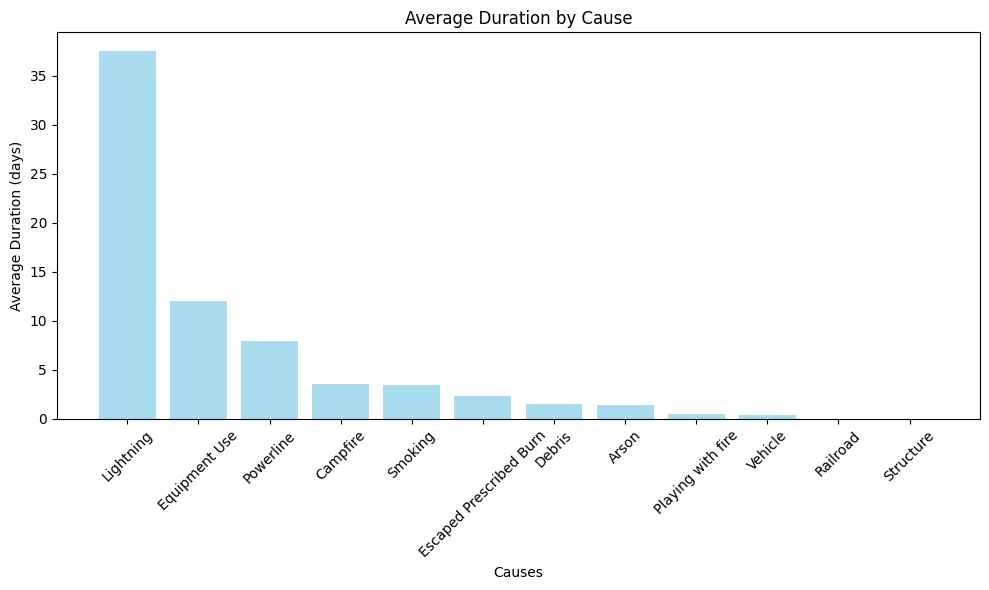

In [11]:
source_clean_df = source_clean_df.sort_values(by='Average Duration (days)', ascending=False)
plt.figure(figsize=(10, 6))

plt.bar(source_clean_df['Causes'], source_clean_df['Average Duration (days)'],
        color='skyblue', alpha=0.7)

plt.xlabel('Causes')
plt.ylabel('Average Duration (days)')
plt.title('Average Duration by Cause')

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

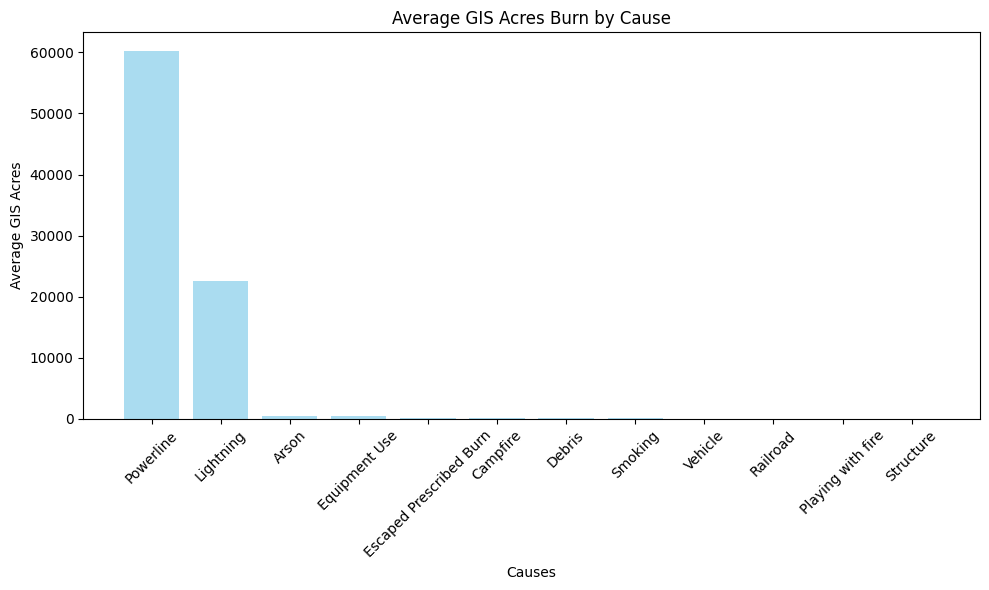

In [12]:
source_clean_df = source_clean_df.sort_values(by='Average GIS Acres', ascending=False)
plt.figure(figsize=(10, 6))

plt.bar(source_clean_df['Causes'], source_clean_df['Average GIS Acres'],
        color='skyblue', alpha=0.7)

plt.xlabel('Causes')
plt.ylabel('Average GIS Acres')
plt.title('Average GIS Acres Burn by Cause')

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

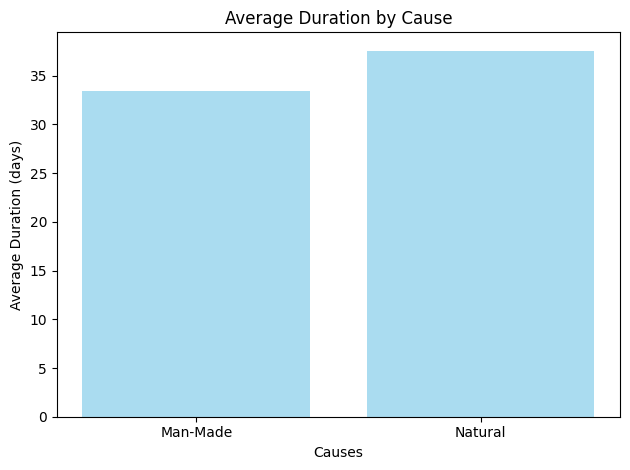

In [13]:
plt.bar(man_vs_nature_df['Causes'], man_vs_nature_df['Average Duration (days)'],
        color='skyblue', alpha=0.7)

plt.xlabel('Causes')
plt.ylabel('Average Duration (days)')
plt.title('Average Duration by Cause')

plt.tight_layout()
plt.show()

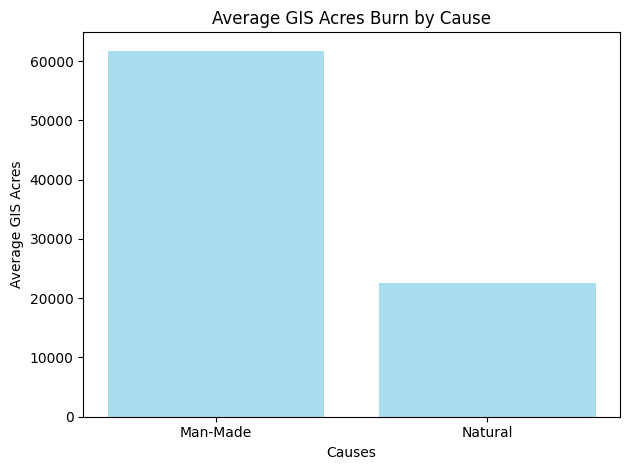

In [14]:
plt.bar(man_vs_nature_df['Causes'], man_vs_nature_df['Average GIS Acres'],
        color='skyblue', alpha=0.7)

plt.xlabel('Causes')
plt.ylabel('Average GIS Acres')
plt.title('Average GIS Acres Burn by Cause')

plt.tight_layout()
plt.show()

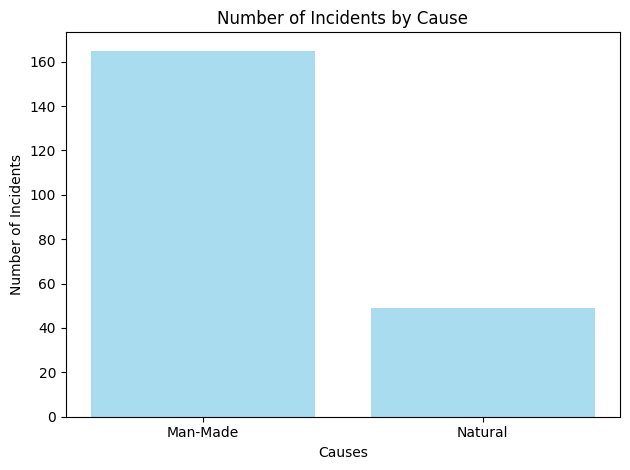

In [15]:
plt.bar(man_vs_nature_df['Causes'], man_vs_nature_df['Number of Occurences (in the Year)'],
        color='skyblue', alpha=0.7)

plt.xlabel('Causes')
plt.ylabel('Number of Incidents')
plt.title('Number of Incidents by Cause')

plt.tight_layout()
plt.show()

In [16]:
# Replace 'vehicle' and 'railroad' with 'transportation' in 'causes' column
fire_gdf['CAUSE'].replace(['Vehicle', 'Railroad'], 'Transportation', inplace=True)


C:\Users\Long\AppData\Local\Temp\ipykernel_44956\3731599140.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  fire_gdf['CAUSE'].replace(['Vehicle', 'Railroad'], 'Transportation', inplace=True)


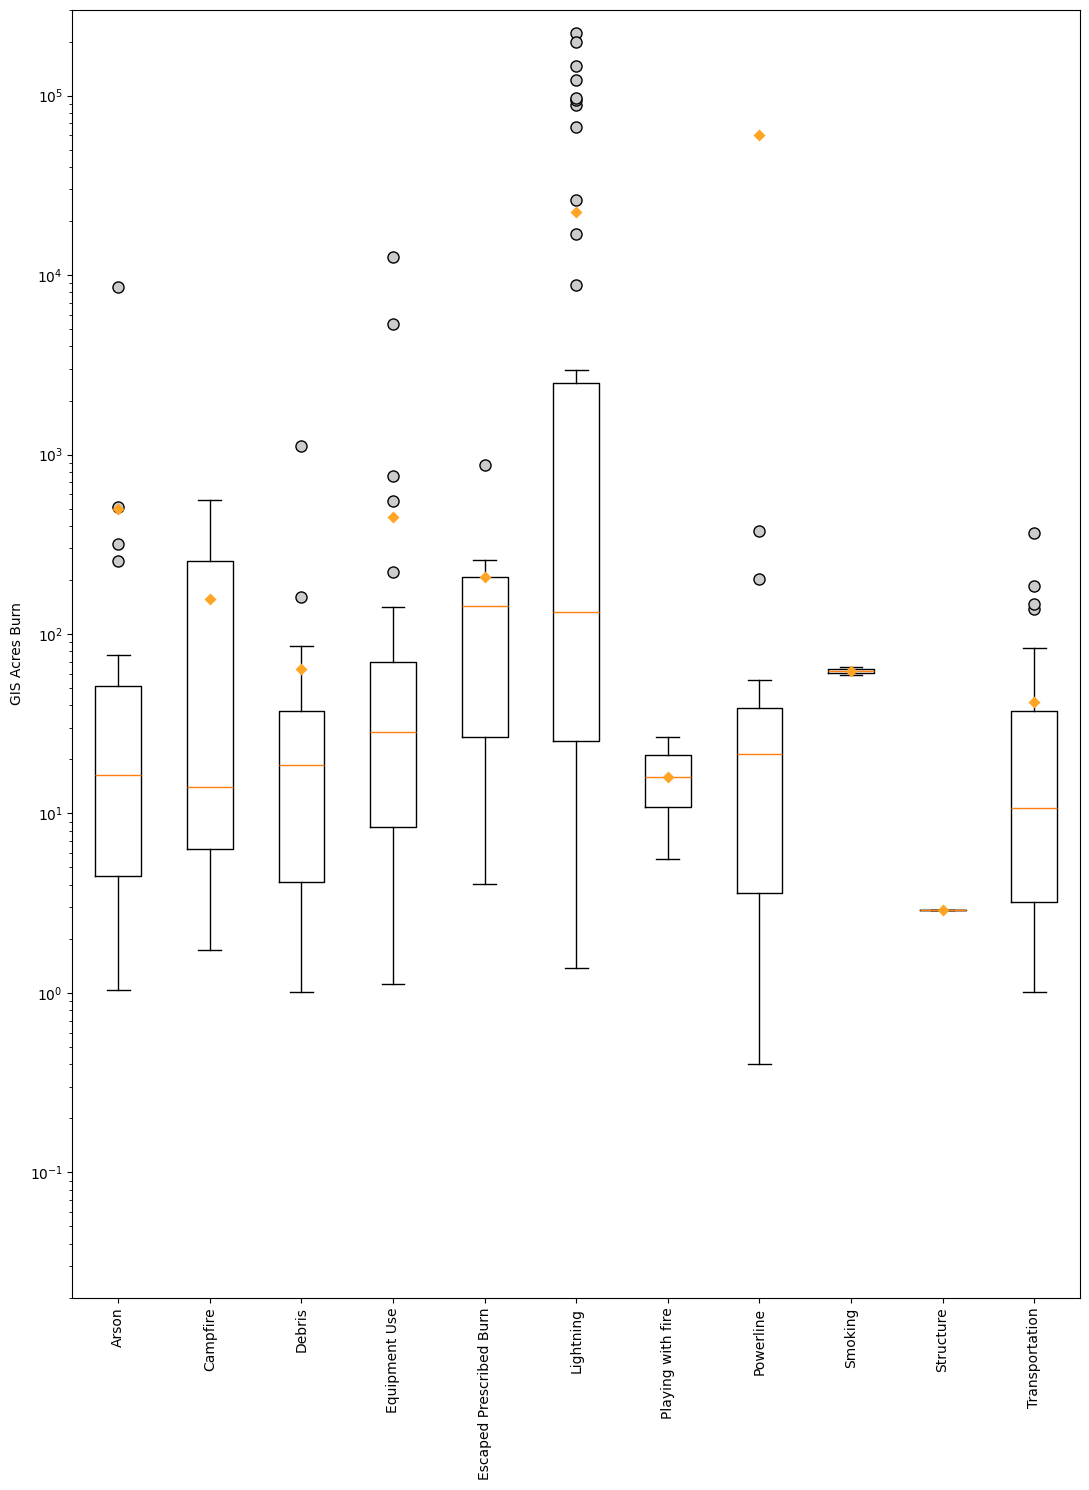

In [17]:
cause_list = fire_gdf['CAUSE'].unique()
value_to_remove = 'Miscellaneous'
new_arr = cause_list[cause_list != value_to_remove]
value_to_remove = 'Unknown/Unidentified'
cause_list = new_arr[new_arr != value_to_remove]
cause_gis = fire_gdf[fire_gdf['CAUSE'].isin(cause_list)]
grouped_data = cause_gis.groupby('CAUSE')['GIS_ACRES'].apply(list)

# # Create a box plot
# Highlight potential outliers by changing their color or style
plt.figure(figsize=(11,15))
meanprops = dict(marker='D', markeredgecolor='none',markerfacecolor='#ffa425')
plt.boxplot(grouped_data.values, tick_labels=grouped_data.index, showfliers=True, patch_artist=False, 
            flierprops=dict(marker='o', markerfacecolor='#ccc', markersize=8), meanprops = meanprops,showmeans = True
)

# Add labels and title
plt.ylim(0.02, 300000)
plt.xticks(rotation=90)
plt.ylabel('GIS Acres Burn')
plt.yscale('log')
plt.tight_layout()
plt.show()